In [72]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

%matplotlib inline

In [73]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [74]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

In [75]:
def ObtainMSE(data, theta0):
    res = ddict(dict)
    for key in data.keys():
        datum = np.squeeze(np.array(data[key]))
        res[key]["Bias"] = np.mean(datum-theta0, axis=1)
        res[key]["Var"] = np.var(datum, axis=1)
        res[key]["MSE"] = np.mean((datum-theta0)**2, axis=1)
    return res

### The work path

In [76]:
root = Path(f"./results/")

## 0. Preprocess the data

In [77]:
def parse_sresult(datum):
    res = {
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPD1" : datum["UIPD1"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "UIPJS1": datum["UIPJS1"]["thetah"],
        "NPP": datum["NPP"]["thetah"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "UIPJS":[],
        "UIPD":[],
        "UIPJS1":[],
        "UIPD1":[],
        "NPP":[]
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["UIPD1"].append(simdatum["UIPD1"])
        retres["UIPJS1"].append(simdatum["UIPJS1"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
    return retres

In [78]:
n = 60
dirs = root.glob(f"simR1_mean_*_n{n}")

dirs = list(dirs)
dirs = sorted(dirs, key=sortdir, reverse=False)

In [79]:
theta0s = [0]
for theta0 in theta0s:
    idxs = np.array([sortdir(d) for d in dirs])/100
    idxs = list(np.sort(idxs))
    
    dirs = sorted(dirs, key=sortdir, reverse=False)
    cdir = dirs[idxs.index(theta0)]
    
    simData = root/f"./SimSimR1_mean_p{sortdir(cdir)}_n{n}.pkl"
    print(simData)
    if simData.exists():
        cleanData = load_pkl(simData)
    else:
        cleanData = save_data(cdir)
        with open(simData, "wb") as f:
            pickle.dump(cleanData, f)

results/SimSimR1_mean_p0_n60.pkl


## 1. To obtaining simple format file for a single setting

### Get the current data

In [80]:
theta0 = 0
idxs = np.array([sortdir(d) for d in dirs])/100
idxs = list(np.sort(idxs))
cdir = dirs[idxs.index(theta0)]
simData = root/f"./SimSimR1_mean_p{sortdir(cdir)}_n{n}.pkl"

### Obtain the cleaned data

In [81]:
if simData.exists():
    cleanData = load_pkl(simData)
else:
    cleanData = save_data(cdir)
    with open(simData, "wb") as f:
        pickle.dump(cleanData, f)

In [82]:
cleanData = edict(cleanData)

### Obtain the mean and variance and MSE from the posterior sample

In [83]:
res = ObtainMSE(cleanData, theta0)

In [84]:
Biass = ddict()
for key in res.keys():
    Biass[key] = res[key]["Bias"]
BiasDF = pd.DataFrame(Biass)

In [85]:
Vars = ddict()
for key in res.keys():
    Vars[key] = res[key]["Var"]
VarDF = pd.DataFrame(Vars)

In [86]:
MSEs = ddict()
for key in res.keys():
    MSEs[key] = res[key]["MSE"]
MSEDF = pd.DataFrame(MSEs)

In [87]:
BiasDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP
0.025,-0.190590,-0.189625,-0.197502,-0.196878,-0.132068
0.500,0.115533,0.112641,0.115613,0.110442,0.194228
0.975,0.377708,0.380137,0.393234,0.393896,0.422203


In [88]:
VarDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP
0.025,0.008807,0.011471,0.011390,0.012834,0.009958
0.500,0.019911,0.019894,0.020708,0.020862,0.020077
0.975,0.032531,0.032622,0.032187,0.032369,0.035296


In [89]:
MSEDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP
0.025,0.016753,0.016867,0.016927,0.017256,0.018495
0.500,0.040746,0.040955,0.042225,0.041668,0.061283
0.975,0.159005,0.163043,0.170152,0.172025,0.192833


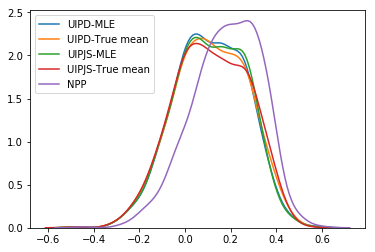

In [91]:
sns.kdeplot(BiasDF["UIPD"], shade=False, label="UIPD-MLE")
sns.kdeplot(BiasDF["UIPD1"], label="UIPD-True mean")
sns.kdeplot(BiasDF["UIPJS"], shade=False, label="UIPJS-MLE")
sns.kdeplot(BiasDF["UIPJS1"], label="UIPJS-True mean")
sns.kdeplot(BiasDF["NPP"], label="NPP")

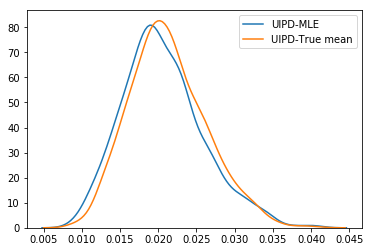

In [92]:
sns.kdeplot(VarDF["UIPD"], shade=False, label="UIPD-MLE")
sns.kdeplot(VarDF["UIPD1"], label="UIPD-True mean")


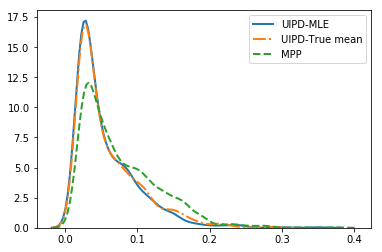

In [114]:
sns.kdeplot(MSEDF["UIPD"],  label="UIPD-MLE", bw=0.01, ls="-", lw=2)
sns.kdeplot(MSEDF["UIPD1"], label="UIPD-True mean", bw=0.01, ls='-.', lw=2)
#sns.kdeplot(MSEDF["UIPJS"], label="UIPJS-MLE", bw=0.01)
#sns.kdeplot(MSEDF["UIPJS1"], label="UIPJS-True mean", bw=0.01)
sns.kdeplot(MSEDF["NPP"], label="MPP", bw=0.01, ls="--", lw=2)

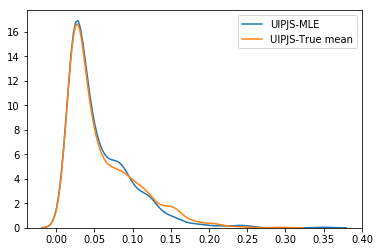

In [98]:
sns.kdeplot(MSEDF["UIPJS"], label="UIPJS-MLE", bw=0.01)
sns.kdeplot(MSEDF["UIPJS1"], label="UIPJS-True mean", bw=0.01)

In [100]:
def is_true(theta0, bs):
    low, up = bs
    return (theta0 > low) and (theta0 < up)


def rejrate(theta0, data, theta):
    reslist = [is_true(theta0, bs=[np.quantile(dat, q=theta), np.quantile(dat, q=1-theta)]) for dat in data] 
    return 1 - np.mean(reslist)


def getRatio(theta0, data):
    p1 = np.mean(data<=theta0)
    p2 = np.mean(data>theta0)
    res = np.min([p1, p2])
    return res



def getQuantile(theta0, data, alp=0.05):
    res = [getRatio(theta0, data=dat) for dat in data]
    return np.quantile(res, q=alp)

In [115]:
sizes = {}
for key, dat in cleanData.items():
    sizes[key] = rejrate(theta0, dat, 0.025)

In [116]:
sizes

{'UIPJS': 0.16100000000000003,
 'UIPD': 0.14700000000000002,
 'UIPJS1': 0.15600000000000003,
 'UIPD1': 0.14600000000000002,
 'NPP': 0.30000000000000004}